In [1]:
from google.colab import files
files.upload()  # upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanaynagarkar","key":"16dbf0042ffb796fb13d284bda07be50"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tanaynagarkar/pc3-data -p /content/
!unzip -q /content/pc3-data.zip -d /content/PC3_data



Dataset URL: https://www.kaggle.com/datasets/tanaynagarkar/pc3-data
License(s): CC0-1.0
100% 3.01G/3.02G [00:33<00:00, 187MB/s]
100% 3.02G/3.02G [00:33<00:00, 95.7MB/s]


In [3]:
!pip install -q git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -q timm==0.9.12

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.3 MB/s eta 0:00:00


In [4]:
import os, cv2, torch, numpy as np
import torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import segmentation_models_pytorch as smp

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_img_dir = "/content/PC3_data/PC3_data_split/train/images"
train_mask_dir = "/content/PC3_data/PC3_data_split/train/masks"
test_img_dir  = "/content/PC3_data/PC3_data_split/test/images"
test_mask_dir = "/content/PC3_data/PC3_data_split/test/masks"

IMG_SIZE = 256
BATCH_SIZE = 4
EPOCHS = 40
SAVE_PATH = "/content/drive/MyDrive/finetuned.pth"


class XrayDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size):
        self.imgs = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        self.img_dir, self.mask_dir, self.img_size = img_dir, mask_dir, img_size
    def __len__(self): return len(self.imgs)
    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.img_dir, self.imgs[idx]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(self.mask_dir, self.masks[idx]), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.img_size, self.img_size)).astype(np.float32) / 255.0
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        mask = (mask > 127).astype(np.float32)
        img = np.stack([img, img, img], axis=0)
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

train_ds = XrayDataset(train_img_dir, train_mask_dir, IMG_SIZE)
test_ds  = XrayDataset(test_img_dir, test_mask_dir, IMG_SIZE)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)



ENCODER = "mit_b2"
MODEL = smp.MAnet(
    encoder_name=ENCODER,
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(DEVICE)

# --- Losses ---
loss_bce = nn.BCEWithLogitsLoss()
def dice_loss_from_logits(pred_logits, target, smooth=1e-6):
    pred = torch.sigmoid(pred_logits)
    pred_flat = pred.view(pred.shape[0], -1)
    target_flat = target.view(target.shape[0], -1)
    intersection = (pred_flat * target_flat).sum(dim=1)
    dice = (2 * intersection + smooth) / (pred_flat.sum(dim=1) + target_flat.sum(dim=1) + smooth)
    return 1 - dice.mean()

def hybrid_loss(pred_logits, target):
    return 0.5 * loss_bce(pred_logits, target) + 0.5 * dice_loss_from_logits(pred_logits, target)

# --- Optimizer & Scheduler ---
optimizer = optim.Adam(MODEL.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

# --- Metrics ---
def compute_batch_metrics(pred_logits, target, thr=0.5):
    pred = torch.sigmoid(pred_logits)
    pred_bin = (pred > thr).float()
    target = target.float()
    ious, dices, precisions, recalls, specificities = [], [], [], [], []
    for i in range(pred_bin.shape[0]):
        p, t = pred_bin[i].view(-1), target[i].view(-1)
        tp = (p * t).sum().item()
        tn = ((1 - p) * (1 - t)).sum().item()
        fp = (p * (1 - t)).sum().item()
        fn = ((1 - p) * t).sum().item()
        iou = tp / (tp + fp + fn + 1e-7)
        dice = (2 * tp) / (2 * tp + fp + fn + 1e-7)
        precision = tp / (tp + fp + 1e-7)
        recall = tp / (tp + fn + 1e-7)
        specificity = tn / (tn + fp + 1e-7)
        ious.append(iou); dices.append(dice); precisions.append(precision); recalls.append(recall); specificities.append(specificity)
    return np.mean(ious), np.mean(dices), np.mean(precisions), np.mean(recalls), np.mean(specificities)

# --- Training Loop ---
best_val_loss = 1e9
for epoch in range(1, EPOCHS+1):
    MODEL.train()
    epoch_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        logits = MODEL(imgs)
        loss = hybrid_loss(logits, masks)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    MODEL.eval()
    val_loss = 0.0
    iou_list, dice_list, prec_list, rec_list, spec_list = [], [], [], [], []
    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc="Val"):
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            logits = MODEL(imgs)
            val_loss += hybrid_loss(logits, masks).item()
            iou, dice, p, r, s = compute_batch_metrics(logits, masks)
            iou_list.append(iou); dice_list.append(dice); prec_list.append(p); rec_list.append(r); spec_list.append(s)
    val_loss /= len(test_loader)
    scheduler.step(val_loss)
    mean_iou, mean_dice = np.mean(iou_list), np.mean(dice_list)
    mean_prec, mean_rec, mean_spec = np.mean(prec_list), np.mean(rec_list), np.mean(spec_list)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(MODEL.state_dict(), SAVE_PATH)
    print(f"Epoch {epoch} train_loss={epoch_loss:.6f} val_loss={val_loss:.6f} IoU={mean_iou:.4f} Dice={mean_dice:.4f} Prec={mean_prec:.4f} Rec={mean_rec:.4f} Spec={mean_spec:.4f}")

# --- Final Evaluation ---
MODEL.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
MODEL.eval()
all_ious, all_dices, all_prec, all_rec, all_spec = [], [], [], [], []
with torch.no_grad():
    for imgs, masks in tqdm(test_loader, desc="Final Eval"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        logits = MODEL(imgs)
        iou, dice, p, r, s = compute_batch_metrics(logits, masks)
        all_ious.append(iou); all_dices.append(dice); all_prec.append(p); all_rec.append(r); all_spec.append(s)
print("Results — IoU:", np.mean(all_ious), "Dice:", np.mean(all_dices), "Precision:", np.mean(all_prec), "Recall:", np.mean(all_rec), "Specificity:", np.mean(all_spec))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/98.9M [00:00<?, ?B/s]

Val: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s]


Epoch 1 train_loss=0.533249 val_loss=0.447004 IoU=0.8408 Dice=0.9128 Prec=0.8594 Rec=0.9767 Spec=0.9494


Val: 100%|██████████| 29/29 [00:12<00:00,  2.37it/s]


Epoch 2 train_loss=0.418563 val_loss=0.397441 IoU=0.8703 Dice=0.9300 Prec=0.8893 Rec=0.9774 Spec=0.9619


Val: 100%|██████████| 29/29 [00:12<00:00,  2.41it/s]


Epoch 3 train_loss=0.325882 val_loss=0.285469 IoU=0.8852 Dice=0.9385 Prec=0.9083 Rec=0.9733 Spec=0.9691


Val: 100%|██████████| 29/29 [00:11<00:00,  2.42it/s]


Epoch 4 train_loss=0.246249 val_loss=0.231392 IoU=0.9091 Dice=0.9518 Prec=0.9382 Rec=0.9680 Spec=0.9801


Val: 100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


Epoch 5 train_loss=0.200209 val_loss=0.190190 IoU=0.9138 Dice=0.9543 Prec=0.9462 Rec=0.9647 Spec=0.9830


Val: 100%|██████████| 29/29 [00:11<00:00,  2.48it/s]


Epoch 6 train_loss=0.164728 val_loss=0.159558 IoU=0.9094 Dice=0.9518 Prec=0.9376 Rec=0.9690 Spec=0.9802


Val: 100%|██████████| 29/29 [00:12<00:00,  2.41it/s]


Epoch 7 train_loss=0.137911 val_loss=0.133587 IoU=0.9155 Dice=0.9554 Prec=0.9526 Rec=0.9600 Spec=0.9851


Val: 100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


Epoch 8 train_loss=0.118266 val_loss=0.117458 IoU=0.9190 Dice=0.9572 Prec=0.9564 Rec=0.9599 Spec=0.9863


Val: 100%|██████████| 29/29 [00:10<00:00,  2.67it/s]


Epoch 9 train_loss=0.102393 val_loss=0.101787 IoU=0.9182 Dice=0.9568 Prec=0.9599 Rec=0.9555 Spec=0.9876


Val: 100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


Epoch 10 train_loss=0.086022 val_loss=0.091884 IoU=0.9133 Dice=0.9538 Prec=0.9455 Rec=0.9650 Spec=0.9833


Val: 100%|██████████| 29/29 [00:12<00:00,  2.42it/s]


Epoch 11 train_loss=0.074813 val_loss=0.082415 IoU=0.9215 Dice=0.9586 Prec=0.9601 Rec=0.9589 Spec=0.9877


Val: 100%|██████████| 29/29 [00:11<00:00,  2.46it/s]


Epoch 12 train_loss=0.064356 val_loss=0.072832 IoU=0.9197 Dice=0.9576 Prec=0.9622 Rec=0.9549 Spec=0.9882


Val: 100%|██████████| 29/29 [00:12<00:00,  2.37it/s]


Epoch 13 train_loss=0.058569 val_loss=0.072255 IoU=0.9188 Dice=0.9568 Prec=0.9613 Rec=0.9549 Spec=0.9883


Val: 100%|██████████| 29/29 [00:12<00:00,  2.39it/s]


Epoch 14 train_loss=0.052241 val_loss=0.070262 IoU=0.9191 Dice=0.9570 Prec=0.9669 Rec=0.9498 Spec=0.9904


Val: 100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


Epoch 15 train_loss=0.048088 val_loss=0.064426 IoU=0.9225 Dice=0.9592 Prec=0.9647 Rec=0.9555 Spec=0.9890


Val: 100%|██████████| 29/29 [00:12<00:00,  2.41it/s]


Epoch 16 train_loss=0.044169 val_loss=0.067101 IoU=0.9168 Dice=0.9559 Prec=0.9614 Rec=0.9526 Spec=0.9880


Val: 100%|██████████| 29/29 [00:12<00:00,  2.41it/s]


Epoch 17 train_loss=0.041051 val_loss=0.065607 IoU=0.9178 Dice=0.9563 Prec=0.9705 Rec=0.9448 Spec=0.9913


Val: 100%|██████████| 29/29 [00:12<00:00,  2.38it/s]


Epoch 18 train_loss=0.037918 val_loss=0.067328 IoU=0.9165 Dice=0.9555 Prec=0.9622 Rec=0.9517 Spec=0.9891


Val: 100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


Epoch 19 train_loss=0.036923 val_loss=0.065679 IoU=0.9172 Dice=0.9560 Prec=0.9634 Rec=0.9510 Spec=0.9893


Val: 100%|██████████| 29/29 [00:10<00:00,  2.72it/s]


Epoch 20 train_loss=0.036556 val_loss=0.063812 IoU=0.9185 Dice=0.9568 Prec=0.9650 Rec=0.9508 Spec=0.9895


Val: 100%|██████████| 29/29 [00:12<00:00,  2.41it/s]


Epoch 21 train_loss=0.034067 val_loss=0.063610 IoU=0.9205 Dice=0.9579 Prec=0.9687 Rec=0.9493 Spec=0.9906


Val: 100%|██████████| 29/29 [00:12<00:00,  2.38it/s]


Epoch 22 train_loss=0.029290 val_loss=0.064004 IoU=0.9206 Dice=0.9580 Prec=0.9665 Rec=0.9517 Spec=0.9900


Val: 100%|██████████| 29/29 [00:12<00:00,  2.35it/s]


Epoch 23 train_loss=0.026621 val_loss=0.065834 IoU=0.9182 Dice=0.9566 Prec=0.9639 Rec=0.9517 Spec=0.9892


Val: 100%|██████████| 29/29 [00:11<00:00,  2.63it/s]


Epoch 24 train_loss=0.024501 val_loss=0.065372 IoU=0.9195 Dice=0.9573 Prec=0.9708 Rec=0.9462 Spec=0.9914


Val: 100%|██████████| 29/29 [00:12<00:00,  2.37it/s]


Epoch 25 train_loss=0.023794 val_loss=0.065685 IoU=0.9198 Dice=0.9574 Prec=0.9633 Rec=0.9539 Spec=0.9890


Val: 100%|██████████| 29/29 [00:12<00:00,  2.38it/s]


Epoch 26 train_loss=0.022291 val_loss=0.065964 IoU=0.9197 Dice=0.9575 Prec=0.9680 Rec=0.9491 Spec=0.9904


Val: 100%|██████████| 29/29 [00:11<00:00,  2.51it/s]


Epoch 27 train_loss=0.020922 val_loss=0.066949 IoU=0.9196 Dice=0.9574 Prec=0.9668 Rec=0.9502 Spec=0.9901


Val: 100%|██████████| 29/29 [00:12<00:00,  2.36it/s]


Epoch 28 train_loss=0.018826 val_loss=0.067425 IoU=0.9199 Dice=0.9574 Prec=0.9674 Rec=0.9499 Spec=0.9904


Val: 100%|██████████| 29/29 [00:11<00:00,  2.57it/s]


Epoch 29 train_loss=0.017333 val_loss=0.068719 IoU=0.9196 Dice=0.9573 Prec=0.9672 Rec=0.9498 Spec=0.9904


Val: 100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


Epoch 30 train_loss=0.016092 val_loss=0.069829 IoU=0.9196 Dice=0.9573 Prec=0.9628 Rec=0.9541 Spec=0.9889


Val: 100%|██████████| 29/29 [00:12<00:00,  2.42it/s]


Epoch 31 train_loss=0.015756 val_loss=0.069875 IoU=0.9200 Dice=0.9576 Prec=0.9633 Rec=0.9541 Spec=0.9890


Val: 100%|██████████| 29/29 [00:10<00:00,  2.73it/s]


Epoch 32 train_loss=0.015325 val_loss=0.070427 IoU=0.9199 Dice=0.9576 Prec=0.9653 Rec=0.9520 Spec=0.9897


Val: 100%|██████████| 29/29 [00:12<00:00,  2.38it/s]


Epoch 33 train_loss=0.014976 val_loss=0.070725 IoU=0.9202 Dice=0.9577 Prec=0.9636 Rec=0.9539 Spec=0.9891


Val: 100%|██████████| 29/29 [00:12<00:00,  2.41it/s]


Epoch 34 train_loss=0.013938 val_loss=0.071297 IoU=0.9203 Dice=0.9578 Prec=0.9638 Rec=0.9539 Spec=0.9892


Val: 100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


Epoch 35 train_loss=0.013483 val_loss=0.072097 IoU=0.9202 Dice=0.9578 Prec=0.9643 Rec=0.9533 Spec=0.9894


Val: 100%|██████████| 29/29 [00:12<00:00,  2.42it/s]


Epoch 36 train_loss=0.013112 val_loss=0.072628 IoU=0.9201 Dice=0.9577 Prec=0.9658 Rec=0.9517 Spec=0.9898


Val: 100%|██████████| 29/29 [00:11<00:00,  2.57it/s]


Epoch 37 train_loss=0.012843 val_loss=0.073502 IoU=0.9200 Dice=0.9576 Prec=0.9623 Rec=0.9551 Spec=0.9887


Val: 100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


Epoch 38 train_loss=0.012306 val_loss=0.073757 IoU=0.9205 Dice=0.9579 Prec=0.9653 Rec=0.9526 Spec=0.9897


Val: 100%|██████████| 29/29 [00:12<00:00,  2.42it/s]


Epoch 39 train_loss=0.012362 val_loss=0.074028 IoU=0.9202 Dice=0.9577 Prec=0.9649 Rec=0.9526 Spec=0.9896


Val: 100%|██████████| 29/29 [00:10<00:00,  2.74it/s]


Epoch 40 train_loss=0.011764 val_loss=0.074568 IoU=0.9202 Dice=0.9578 Prec=0.9635 Rec=0.9541 Spec=0.9890


Final Eval: 100%|██████████| 29/29 [00:11<00:00,  2.52it/s]

Results — IoU: 0.9204679552494965 Dice: 0.9579080216876971 Precision: 0.9686906220265696 Recall: 0.9492907328160419 Specificity: 0.990649102428272


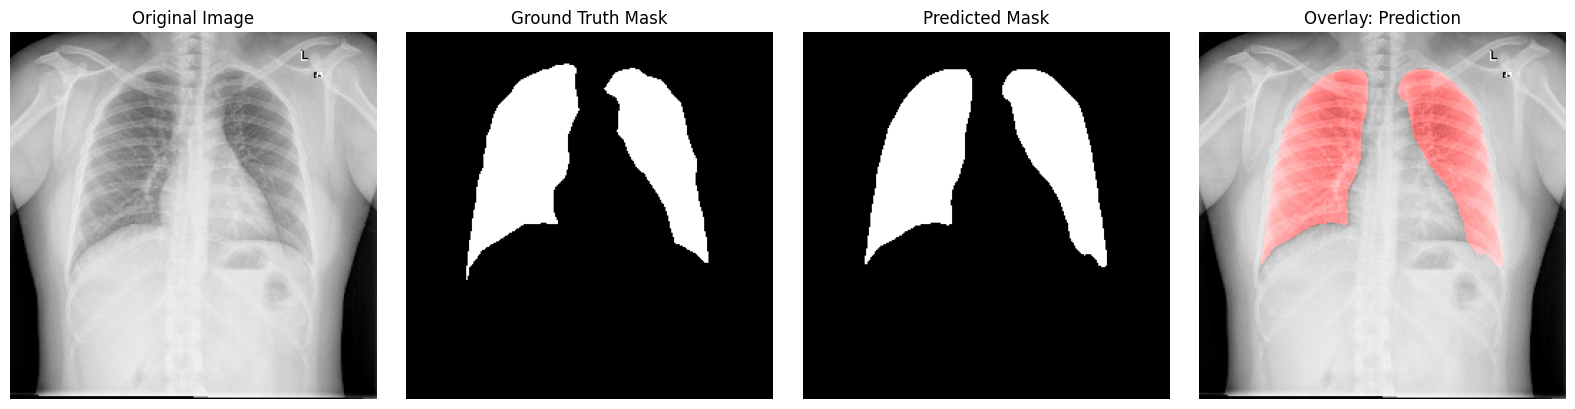

In [7]:
import torch, matplotlib.pyplot as plt, random, os, cv2, numpy as np
import segmentation_models_pytorch as smp

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256
TEST_IMG_DIR = "/content/PC3_data/PC3_data_split/test/images"
TEST_MASK_DIR = "/content/PC3_data/PC3_data_split/test/masks"
MODEL_PATH = "/content/drive/MyDrive/finetuned.pth"


class XrayDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, mask_dir, img_size):
        self.img_dir, self.mask_dir, self.img_size = img_dir, mask_dir, img_size
        self.images = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.img_dir, self.images[idx]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(self.mask_dir, self.masks[idx]), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.img_size, self.img_size)).astype(np.float32)/255.0
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        mask = (mask > 127).astype(np.float32)
        img = np.stack([img,img,img], axis=0)
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

# Load dataset
test_dataset = XrayDataset(TEST_IMG_DIR, TEST_MASK_DIR, IMG_SIZE)

# Load model
MODEL = smp.MAnet(encoder_name="mit_b2", encoder_weights="imagenet", in_channels=3, classes=1, activation=None).to(DEVICE)
MODEL.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
MODEL.eval()

# Pick a random sample
idx = random.randint(0, len(test_dataset)-1)
img, mask = test_dataset[idx]
img_input = img.unsqueeze(0).to(DEVICE)

# Inference
with torch.no_grad():
    pred = torch.sigmoid(MODEL(img_input)).cpu().squeeze().numpy()
    pred_bin = (pred > 0.5).astype(float)

# Prepare for display
img_disp = img.permute(1,2,0).numpy()
mask_disp = mask.squeeze().numpy()
pred_disp = pred_bin

overlay = img_disp.copy()
overlay[..., 0] += pred_disp * 0.5  # Red overlay for prediction
overlay = np.clip(overlay, 0, 1)

# Plot everything
plt.figure(figsize=(16,4))
plt.subplot(1,4,1); plt.imshow(img_disp); plt.title("Original Image"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(mask_disp, cmap="gray"); plt.title("Ground Truth Mask"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(pred_disp, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(overlay); plt.title("Overlay: Prediction"); plt.axis("off")
plt.tight_layout(); plt.show()
